<a href="https://colab.research.google.com/github/anveshveeramalla/Anvesh_INFO5731_SPRING2022/blob/main/In_class_exercise_04_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fourth in-class-exercise (40 points in total, 03/29/2022)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
# Write your code here
import nltk; nltk.download('stopwords')
import spacy.cli
spacy.cli.download("en_core_web_sm")

!pip install pyLDAvis

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .mio5_utils import VarReader5


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [7]:
df = pd.read_csv('/content/sample_data/Musical_instruments_reviews.csv')

# Convert to list
data = df.reviewText.values.tolist()

# printing sample
pprint(data[:1])

["Not much to write about here, but it does exactly what it's supposed to. "
 'filters out the pop sounds. now my recordings are much more crisp. it is one '
 'of the lowest prices pop filters on amazon so might as well buy it, they '
 'honestly work the same despite their pricing,']


In [8]:
# converting sentenses to words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['not', 'much', 'to', 'write', 'about', 'here', 'but', 'it', 'does', 'exactly', 'what', 'it', 'supposed', 'to', 'filters', 'out', 'the', 'pop', 'sounds', 'now', 'my', 'recordings', 'are', 'much', 'more', 'crisp', 'it', 'is', 'one', 'of', 'the', 'lowest', 'prices', 'pop', 'filters', 'on', 'amazon', 'so', 'might', 'as', 'well', 'buy', 'it', 'they', 'honestly', 'work', 'the', 'same', 'despite', 'their', 'pricing']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['not', 'much', 'to', 'write', 'about', 'here', 'but', 'it', 'does', 'exactly', 'what', 'it', 'supposed', 'to', 'filters', 'out', 'the', 'pop', 'sounds', 'now', 'my', 'recordings', 'are', 'much', 'more', 'crisp', 'it', 'is', 'one', 'of', 'the', 'lowest', 'prices', 'pop_filters', 'on', 'amazon', 'so', 'might', 'as', 'well', 'buy', 'it', 'they', 'honestly', 'work', 'the', 'same', 'despite', 'their', 'pricing']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['much', 'write', 'exactly', 'suppose', 'filter', 'pop', 'sound', 'recording', 'much', 'crisp', 'low', 'price', 'may', 'well', 'buy', 'honestly', 'work', 'pricing']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]


In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('buy', 1),
  ('crisp', 1),
  ('exactly', 1),
  ('filter', 1),
  ('honestly', 1),
  ('low', 1),
  ('may', 1),
  ('much', 2),
  ('pop', 1),
  ('price', 1),
  ('pricing', 1),
  ('recording', 1),
  ('sound', 1),
  ('suppose', 1),
  ('well', 1),
  ('work', 1),
  ('write', 1)]]

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.245*"string" + 0.088*"tune" + 0.073*"tuner" + 0.069*"capo" + '
  '0.030*"design" + 0.027*"tension" + 0.024*"tuning" + 0.021*"fret" + '
  '0.020*"finger" + 0.020*"gauge"'),
 (1,
  '0.061*"cable" + 0.053*"snark" + 0.050*"plug" + 0.040*"include" + '
  '0.038*"side" + 0.036*"model" + 0.035*"leave" + 0.030*"level" + '
  '0.026*"sturdy" + 0.024*"inexpensive"'),
 (2,
  '0.135*"right" + 0.113*"effect" + 0.041*"already" + 0.032*"thin" + '
  '0.028*"sharp" + 0.027*"edge" + 0.026*"pad" + 0.026*"preset" + '
  '0.021*"highly_recommende" + 0.020*"jam"'),
 (3,
  '0.050*"clip" + 0.038*"ear" + 0.033*"position" + 0.032*"ipad" + '
  '0.028*"driver" + 0.025*"capos" + 0.025*"clamp" + 0.025*"screen" + '
  '0.023*"fairly" + 0.022*"weight"'),
 (4,
  '0.121*"time" + 0.069*"small" + 0.061*"long" + 0.061*"bit" + 0.053*"enough" '
  '+ 0.049*"end" + 0.042*"last" + 0.032*"metal" + 0.028*"top" + 0.024*"heavy"'),
 (5,
  '0.075*"fender" + 0.060*"money" + 0.059*"run" + 0.044*"open" + 0.043*"input" '
  '+ 0.04

In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.547546394661564

Coherence Score:  0.26339226223388673


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.438180  0.169830       1        1  36.606257
15    -0.105609 -0.415231       2        1   8.084828
7     -0.060749 -0.072922       3        1   5.024531
4     -0.043171  0.005573       4        1   4.526447
0     -0.079524 -0.081806       5        1   4.019510
18     0.002563  0.002770       6        1   3.984762
12     0.030271  0.009499       7        1   3.533725
6      0.029239  0.013754       8        1   3.350367
10     0.037923  0.019692       9        1   3.328821
1      0.000207  0.056015      10        1   3.201393
19     0.049215  0.019528      11        1   2.974932
8      0.036893  0.039522      12        1   2.831052
14     0.048791  0.022436      13        1   2.817882
17     0.064136  0.028016      14        1   2.559908
9      0.062099  0.025611      15        1   2.525492
5      0.069054  0.026942      16        1   2.241303
3      0.067866  0.030903      17        1   2.239580
16     0.078266  0.031375      18        1   2.177272
11     0.068929  0.039052      19        1   2.134379
2      0.081781  0.029441      20        1   1.837560, topic_info=             Term         Freq        Total Category  logprob  loglift
654        string  3703.000000  3703.000000  Default  30.0000  30.0000
144         pedal  2868.000000  2868.000000  Default  29.0000  29.0000
334          easy  1954.000000  1954.000000  Default  28.0000  28.0000
167          time  2068.000000  2068.000000  Default  27.0000  27.0000
878          tone  2032.000000  2032.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1834    correctly    51.081756    51.809678  Topic20  -4.9084   3.9826
2072        jumbo    45.101625    45.829548  Topic20  -5.0329   3.9807
500          loss    44.058737    44.786660  Topic20  -5.0563   3.9803
2075        print    42.151698    42.879621  Topic20  -5.1005   3.9796
5180  sensitivity    42.043562    42.771485  Topic20  -5.1031   3.9796

[639 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1725     15  0.993241     ability
75       19  0.998086        able
532      11  0.992951  absolutely
3240     18  0.991120    accuracy
3462      8  0.999102    accurate
...     ...       ...         ...
15        1  0.999633        work
378      11  0.991840       worry
125      11  0.999480       worth
74        1  0.999900       would
674       5  0.994257         yet

[619 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 16, 8, 5, 1, 19, 13, 7, 11, 2, 20, 9, 15, 18, 10, 6, 4, 17, 12, 3])

In [17]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

openjdk version "11.0.14" 2022-01-18
OpenJDK Runtime Environment (build 11.0.14+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.14+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
--2022-04-04 04:43:49--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-04-04 04:43:50--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  9.65MB/s    in 1.6s    

2022-04-04 04:43:52 (9.65 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive: 

In [18]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'
corpus_path = 'transcripts'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(6,
  [('guitar', 0.32883746405586745),
   ('acoustic', 0.05737368204847323),
   ('electric', 0.03245241681500753),
   ('neck', 0.02136108448582774),
   ('finish', 0.02136108448582774),
   ('clean', 0.018485553881966314),
   ('pickup', 0.016910858551280297),
   ('body', 0.015062303163083664),
   ('instrument', 0.014377653019307135),
   ('leave', 0.014309188004929481)]),
 (10,
  [('record', 0.0374331550802139),
   ('unit', 0.027509785544958375),
   ('microphone', 0.021996802469816418),
   ('recording', 0.01907492143999118),
   ('studio', 0.018689012624731244),
   ('device', 0.018027454655714207),
   ('mic', 0.01620817024091736),
   ('headphone', 0.01609791057941452),
   ('audio', 0.013506808534097801),
   ('input', 0.012955510226583604)]),
 (15,
  [('stand', 0.1108580106302202),
   ('hold', 0.05432456685304066),
   ('sturdy', 0.02864637260992614),
   ('heavy', 0.024297646165527716),
   ('solid', 0.024021536550010353),
   ('music', 0.02132946779871609),
   ('place', 0.02043211154828467)

In [22]:
# computing coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

KeyboardInterrupt: ignored

In [21]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

NameError: ignored

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model 1, because it has high coherence and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [23]:
# Write your code here

# importing the required library
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import nltk; nltk.download('stopwords')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
# loading data
def load_data(path,file_name):
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

In [25]:
# data preprocessing
def preprocess_data(doc_set):
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [26]:
# preparing clean data
def prepare_corpus(doc_clean):
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [27]:
# creating an LSA model using Gensim
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [28]:
# determining the number of topics
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [30]:
# LSA Model
number_of_topics=7
words=10
document_list,titles=load_data("/content/","/content/sample_data/Musical_instruments_reviews.csv")
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

Total Number of Documents: 10262
[(0, '0.494*"0" + 0.256*"use" + 0.238*"guitar" + 0.211*"sound" + 0.186*"5" + 0.177*"string" + 0.170*"one" + 0.156*"great" + 0.151*"like" + 0.149*"pedal"'), (1, '-0.663*"0" + 0.303*"amp" + 0.299*"pedal" + 0.271*"sound" + 0.149*"tone" + 0.146*"use" + -0.130*"5" + 0.101*"get" + -0.098*"2013" + 0.096*"like"'), (2, '0.674*"string" + 0.381*"guitar" + -0.321*"0" + -0.314*"pedal" + 0.163*"tune" + -0.152*"amp" + 0.114*"play" + 0.081*"tuner" + -0.075*"5" + -0.073*"great"'), (3, '0.394*"string" + 0.372*"pedal" + -0.335*"use" + 0.239*"sound" + -0.221*"mic" + 0.208*"amp" + -0.196*"one" + 0.187*"tone" + 0.177*"0" + -0.174*"record"'), (4, '0.633*"pedal" + -0.561*"amp" + -0.261*"sound" + 0.137*"use" + 0.117*"tuner" + 0.107*"string" + -0.099*"fender" + 0.095*"tune" + -0.087*"mic" + 0.085*"one"'), (5, '0.715*"guitar" + -0.384*"string" + -0.221*"mic" + -0.207*"use" + 0.204*"strap" + 0.155*"pedal" + -0.154*"record" + -0.145*"sound" + 0.099*"amp" + -0.091*"microphon"'), (6,

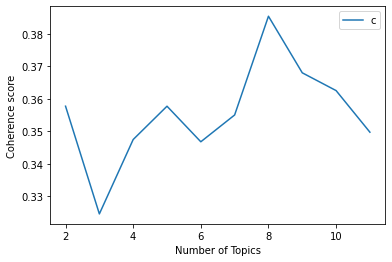

In [31]:
# plotting
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)

In [32]:
# number of topics taking as 4 as it has high coherence at 4 topics
number_of_topics=4
words=10
document_list,titles=load_data("/content/","/content/sample_data/Musical_instruments_reviews.csv")
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

Total Number of Documents: 10262
[(0, '0.494*"0" + 0.256*"use" + 0.238*"guitar" + 0.211*"sound" + 0.186*"5" + 0.177*"string" + 0.170*"one" + 0.156*"great" + 0.151*"like" + 0.149*"pedal"'), (1, '0.663*"0" + -0.303*"amp" + -0.299*"pedal" + -0.271*"sound" + -0.149*"tone" + -0.146*"use" + 0.130*"5" + -0.101*"get" + 0.098*"2013" + -0.096*"like"'), (2, '0.674*"string" + 0.381*"guitar" + -0.321*"0" + -0.314*"pedal" + 0.163*"tune" + -0.152*"amp" + 0.114*"play" + 0.081*"tuner" + -0.075*"5" + -0.073*"great"'), (3, '-0.394*"string" + -0.372*"pedal" + 0.335*"use" + -0.239*"sound" + 0.221*"mic" + -0.208*"amp" + 0.196*"one" + -0.187*"tone" + -0.177*"0" + 0.174*"record"')]


## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [33]:
# Write your code here

!pip install pylda2vec





In [34]:
!pip install git+https://github.com/bmabey/pyLDAvis.git@master#egg=pyLDAvis

  Cloning https://github.com/bmabey/pyLDAvis.git (to revision master) to /tmp/pip-install-tw33_b08/pyldavis_e1babb9e96d04aa7a72424fb0899966e
  Running command git clone -q https://github.com/bmabey/pyLDAvis.git /tmp/pip-install-tw33_b08/pyldavis_e1babb9e96d04aa7a72424fb0899966e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [35]:
import pyLDAvis
pyLDAvis.enable_notebook()

In [36]:
!pip install chainer

     |████████████████████████████████| 1.0 MB 6.7 MB/s 
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967740 sha256=ef649bd7f5306ee271382de3884fcd953903bd416ffe3ffde49731c23fe72bd0
  Stored in directory: /root/.cache/pip/wheels/c8/6a/6f/fd563166cc597e5206e375ea074ea836e5db5dd58421215672
Successfully built chainer


In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_md")

In [ ]:
!pip install jellyfish

In [ ]:
from lda2vec import preprocess, Corpus
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

try:
    import seaborn
except:
    pass

## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [ ]:
# Write your code here

%%capture
!pip install bertopic

In [ ]:
# loading data
import pandas as pd
df = pd.read_csv('review_text.csv')
# Removing Punctuations and Noise
df['data1'] = df['Review'].str.replace('[^\w\s]',"")
df['data'] = df['data1'].str.replace("[^a-zA-Z#]", " ")

# converting the data to list
data = df.data.values.tolist()

#converting all list elements to strings
dataf = []
for ele in data:
  dataf.append(str(ele))

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(dataf)

In [ ]:
freq = topic_model.get_topic_info(); freq.head(5)

In [ ]:
topic_model.get_topic(0)  # Selecting the most frequent topic

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:

topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
topic_model.visualize_heatmap(n_clusters=4, width=1000, height=1000)

In [ ]:
topic_model.visualize_term_rank()

## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)



